<a href="https://colab.research.google.com/github/nemoiitkgp/FWI-Codes-PhD/blob/main/Anticline_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install deepwave scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 MB 24.3 MB/s eta 0:00:00


Device: cuda
Starting Multi-scale Inversion...

--- STAGE 1: Frequency 3.0 Hz ---
Global Epoch 010 | Local Epoch 010 | Loss: 0.087304
Global Epoch 020 | Local Epoch 020 | Loss: 0.042450
Global Epoch 030 | Local Epoch 030 | Loss: 0.022276
Global Epoch 040 | Local Epoch 040 | Loss: 0.014068
Global Epoch 050 | Local Epoch 050 | Loss: 0.009337


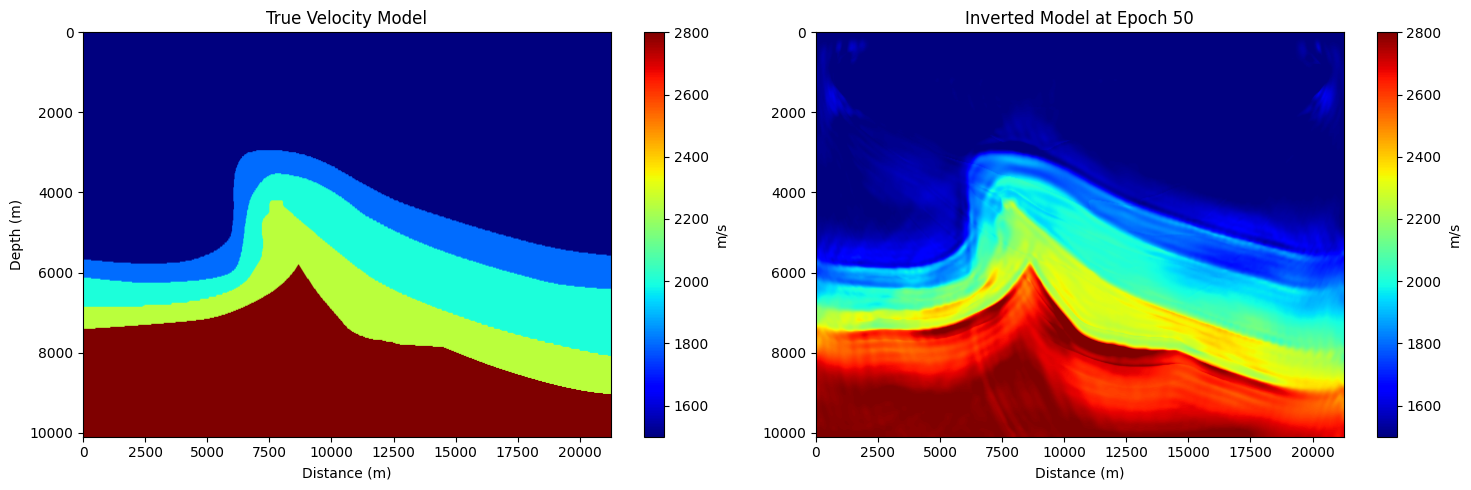

Global Epoch 060 | Local Epoch 060 | Loss: 0.006351
Global Epoch 070 | Local Epoch 070 | Loss: 0.004554
Global Epoch 080 | Local Epoch 080 | Loss: 0.003452
Global Epoch 090 | Local Epoch 090 | Loss: 0.002746
Global Epoch 100 | Local Epoch 100 | Loss: 0.002271


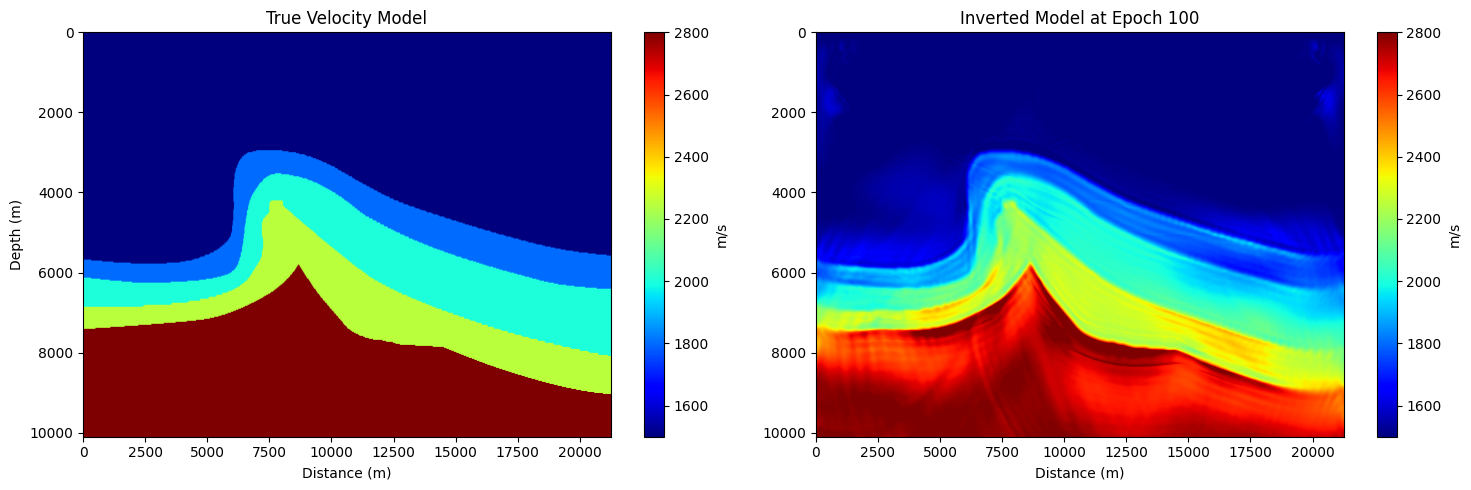


--- STAGE 2: Frequency 7.0 Hz ---
Global Epoch 110 | Local Epoch 010 | Loss: 0.002815
Global Epoch 120 | Local Epoch 020 | Loss: 0.001544
Global Epoch 130 | Local Epoch 030 | Loss: 0.001059
Global Epoch 140 | Local Epoch 040 | Loss: 0.000812
Global Epoch 150 | Local Epoch 050 | Loss: 0.000675


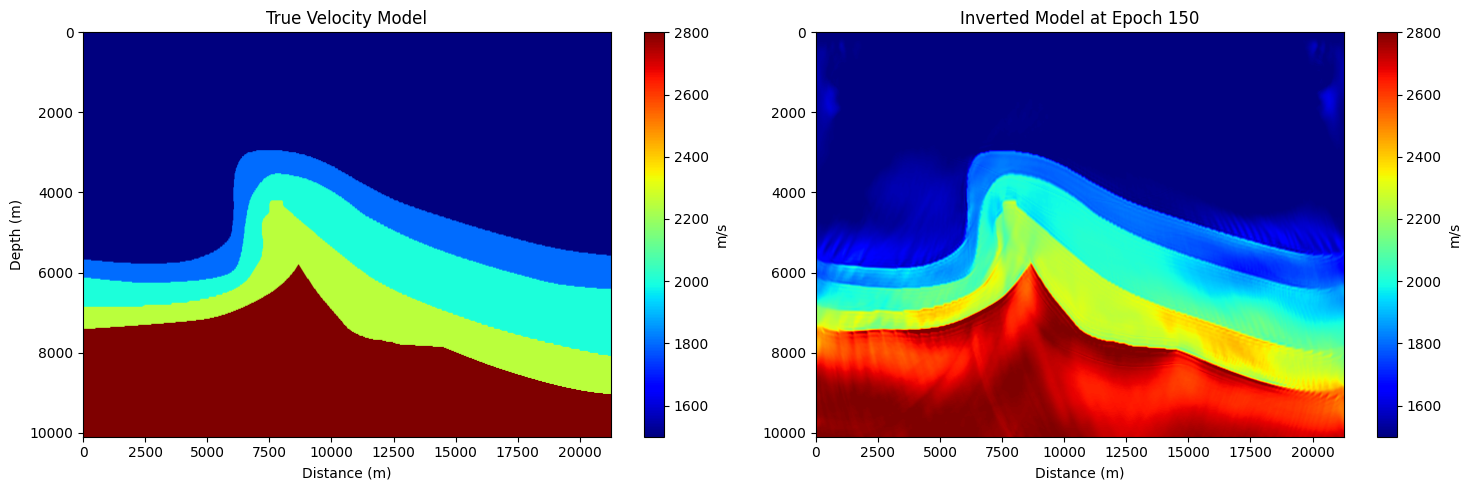

Global Epoch 160 | Local Epoch 060 | Loss: 0.000591
Global Epoch 170 | Local Epoch 070 | Loss: 0.000532
Global Epoch 180 | Local Epoch 080 | Loss: 0.000489
Global Epoch 190 | Local Epoch 090 | Loss: 0.000455
Global Epoch 200 | Local Epoch 100 | Loss: 0.000427


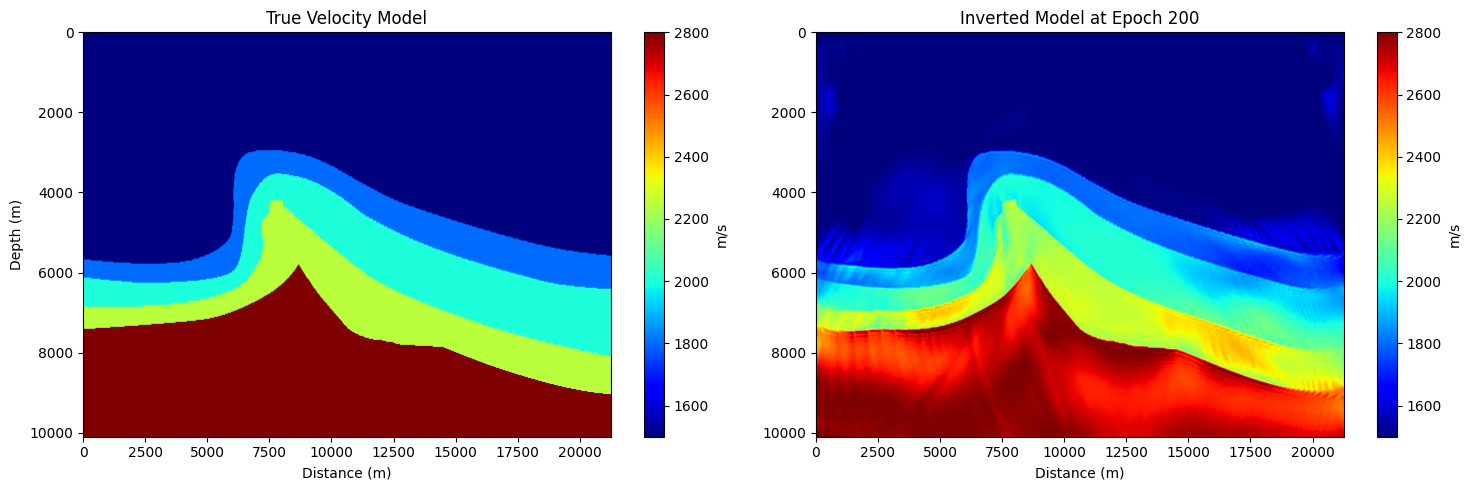

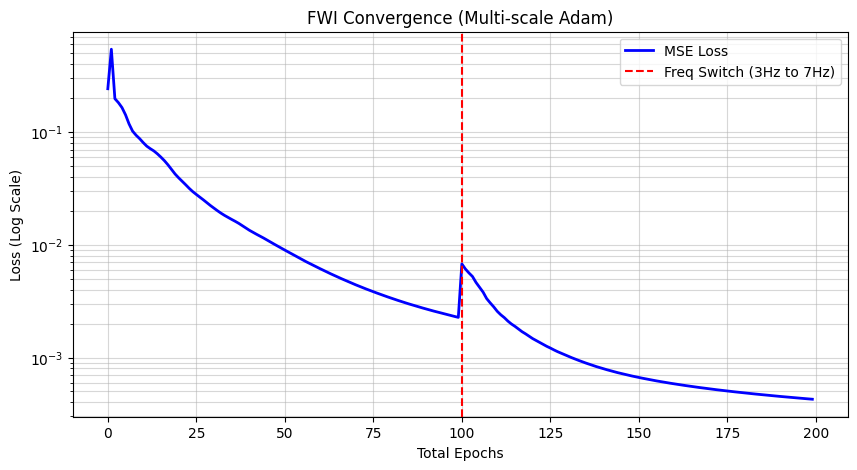

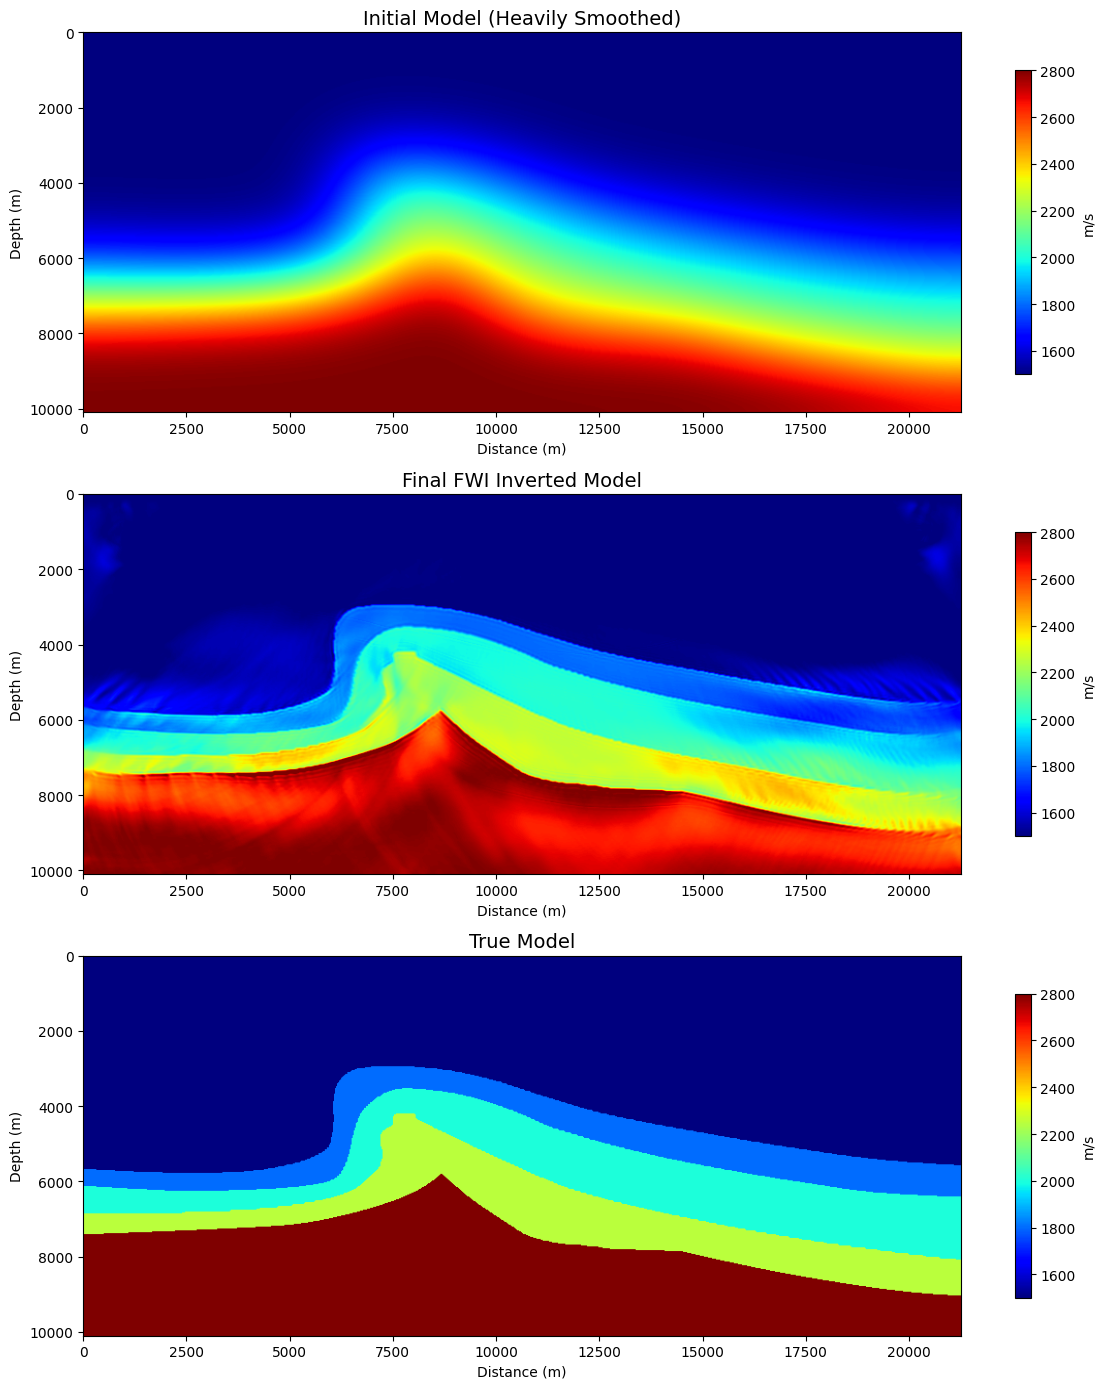

In [ ]:
import numpy as np
import torch
import scipy.io
import gc
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# 0. INITIAL MEMORY CLEAN
gc.collect()
torch.cuda.empty_cache()

# 1. SETTINGS
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 2. INPUT: ANTICLINE MODEL
mat_path = 'anticline_model.mat'
try:
    mat = scipy.io.loadmat(mat_path)
    v_true_np = None
    for key in mat:
        if isinstance(mat[key], np.ndarray):
            arr = np.squeeze(mat[key])
            if arr.ndim == 2:
                v_true_np = arr.astype(np.float32)
                break
    if v_true_np is None: raise ValueError("Invalid 2D array.")
    if np.max(v_true_np) < 10: v_true_np *= 1000.0
except:
    # Fallback synthetic for demonstration if file not found
    print("Warning: .mat file not found. Using fallback synthetic model.")
    v_true_np = 2000 * np.ones((850, 404), dtype=np.float32)
    v_true_np[:, 250:] = 2800

v_true = torch.from_numpy(v_true_np).to(device)
if v_true.shape[0] < v_true.shape[1]: v_true = v_true.T
nx, nz = v_true.shape

# 3. INITIAL MODEL (Strongly Smoothed)
v_init_np = 1/gaussian_filter(1/v_true.cpu().numpy(), sigma=35) # <------------more smoothening change this line (sigma= __)
v_init = torch.from_numpy(v_init_np).to(device)
v1 = v_init.clone().requires_grad_(True)
vmin, vmax = v_true.min().item(), v_true.max().item()

# 4. GEOMETRY
pml_v = 40
dx, dz = 25.0, 25.0
spacing = (dx, dz)
dt = 0.004
nt = 3000
n_shots = 32 # Balanced for illumination and speed on T4

rx = torch.arange(pml_v, nx - pml_v, device=device)
n_receivers_per_shot = len(rx)

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[..., 1] = pml_v + 3
source_loc[:, 0, 0] = torch.linspace(pml_v, nx - pml_v, n_shots).to(torch.long)

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = pml_v + 3
for i in range(n_shots): receiver_loc[i, :, 0] = rx

# 5. MULTI-SCALE STRATEGY & TRACKING
freqs = [3.0, 7.0]
epochs_per_stage = [100, 100]
loss_history = []
global_epoch = 0

# 6. GRADIENT PRECONDITIONER
z_coords = torch.linspace(0, 1, nz, device=device)
z_gain = (z_coords**2 * 40.0 + 1.0).view(1, nz) # Quadratic gain for deep layers
z_gain[:, :15] = 0.0 # Mute the top 15 grid points (shot footprint)

x_gain = torch.ones(nx, device=device)
flank_w = 150
x_gain[:flank_w] = torch.linspace(2.0, 1.0, flank_w, device=device)
x_gain[-flank_w:] = torch.linspace(1.0, 2.0, flank_w, device=device)
full_gain = z_gain * x_gain.view(nx, 1)

# 7. INVERSION
optimizer = torch.optim.Adam([v1], lr=20.0)

print(f"Starting Multi-scale Inversion...")

for stage, (freq, num_epochs) in enumerate(zip(freqs, epochs_per_stage)):
    print(f"\n--- STAGE {stage+1}: Frequency {freq} Hz ---")

    # Generate Ricker for this frequency stage
    source_amp_cpu = deepwave.wavelets.ricker(freq, nt, dt, 1.5/freq).repeat(n_shots, 1, 1)

    # Generate "Observed Data" for this frequency to prevent high-freq noise in early stage
    observed_data_cpu = torch.zeros(n_shots, n_receivers_per_shot, nt)
    with torch.no_grad():
        for i in range(n_shots):
            out = scalar(v_true, spacing, dt, source_amplitudes=source_amp_cpu[i:i+1].to(device),
                         source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                         pml_width=[pml_v]*4, pml_freq=freq)
            observed_data_cpu[i] = out[-1].cpu()
            del out; torch.cuda.empty_cache()

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        epoch_loss = 0
        global_epoch += 1

        # Sequential Shot Loop (T4 VRAM optimization)
        for i in range(n_shots):
            curr_source = source_amp_cpu[i:i+1].to(device)
            curr_obs = observed_data_cpu[i:i+1].to(device)

            out_pred = scalar(v1, spacing, dt, source_amplitudes=curr_source,
                              source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                              pml_width=[pml_v]*4, pml_freq=freq)

            loss = torch.nn.MSELoss()(out_pred[-1], curr_obs)
            (loss / n_shots).backward()
            epoch_loss += loss.item()

            del out_pred, curr_source, curr_obs
            torch.cuda.empty_cache()

        # Gradient Processing
        with torch.no_grad():
            if v1.grad is not None:
                v1.grad *= full_gain # Apply depth gain and surface mute

                # Smooth gradient (wider smoothing for low freq stage)
                current_sigma = 4.0 if stage == 0 else 1.5 # <-------------------------more smoothening change this line
                grad_np = gaussian_filter(v1.grad.cpu().numpy(), sigma=current_sigma)
                v1.grad.copy_(torch.from_numpy(grad_np).to(device))

                optimizer.step()
                v1.clamp_(min=vmin, max=vmax)

        loss_history.append(epoch_loss / n_shots)

        # LOGGING
        if (epoch + 1) % 10 == 0:
            print(f"Global Epoch {global_epoch:03d} | Local Epoch {epoch+1:03d} | Loss: {loss_history[-1]:.6f}")

        # VISUALIZATION EVERY 50 EPOCHS
        if global_epoch % 50 == 0:
            fig, ax = plt.subplots(1, 2, figsize=(15, 5))

            im0 = ax[0].imshow(v_true.cpu().numpy().T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax,
                               extent=[0, nx*dx, nz*dz, 0])
            ax[0].set_title("True Velocity Model")
            ax[0].set_ylabel("Depth (m)"); ax[0].set_xlabel("Distance (m)")
            plt.colorbar(im0, ax=ax[0], label='m/s')

            im1 = ax[1].imshow(v1.detach().cpu().numpy().T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax,
                               extent=[0, nx*dx, nz*dz, 0])
            ax[1].set_title(f"Inverted Model at Epoch {global_epoch}")
            ax[1].set_xlabel("Distance (m)")
            plt.colorbar(im1, ax=ax[1], label='m/s')

            plt.tight_layout()
            plt.show()

# 8. FINAL CONVERGENCE PLOT
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='MSE Loss', color='blue', linewidth=2)
plt.yscale('log')
plt.title("FWI Convergence (Multi-scale Adam)")
plt.xlabel("Total Epochs")
plt.ylabel("Loss (Log Scale)")
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.axvline(x=epochs_per_stage[0], color='red', linestyle='--', label='Freq Switch (3Hz to 7Hz)')
plt.legend()
plt.show()

# 9. FINAL COMPARISON PLOTS
fig, ax = plt.subplots(3, 1, figsize=(12, 14))
imgs = [v_init.cpu().numpy(), v1.detach().cpu().numpy(), v_true.cpu().numpy()]
titles = ["Initial Model (Heavily Smoothed)", "Final FWI Inverted Model", "True Model"]

for i in range(3):
    im = ax[i].imshow(imgs[i].T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax,
                   extent=[0, nx*dx, nz*dz, 0])
    ax[i].set_title(titles[i], fontsize=14)
    ax[i].set_xlabel("Distance (m)")
    ax[i].set_ylabel("Depth (m)")
    fig.colorbar(im, ax=ax[i], label='m/s', shrink=0.8)

plt.tight_layout()
plt.show()

Device: cuda
Starting Multi-scale Inversion...

--- STAGE 1: Frequency 3.0 Hz ---
Global Epoch 010 | Local Epoch 010 | Loss: 0.087301
Global Epoch 020 | Local Epoch 020 | Loss: 0.042449
Global Epoch 030 | Local Epoch 030 | Loss: 0.022275
Global Epoch 040 | Local Epoch 040 | Loss: 0.014068
Global Epoch 050 | Local Epoch 050 | Loss: 0.009337


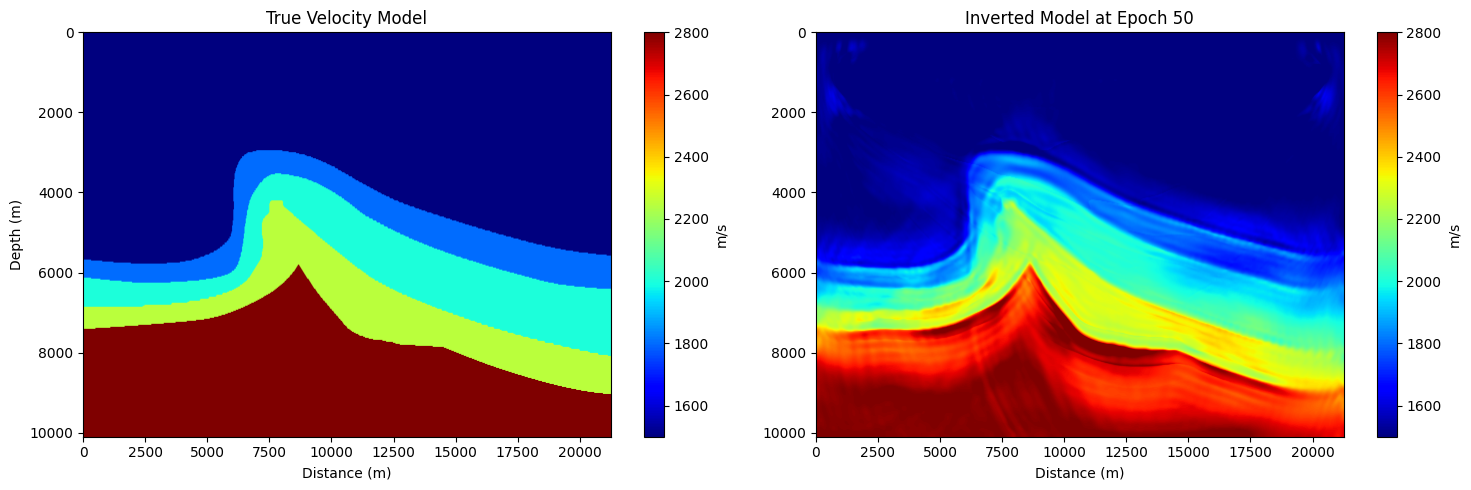

Global Epoch 060 | Local Epoch 060 | Loss: 0.006351
Global Epoch 070 | Local Epoch 070 | Loss: 0.004554
Global Epoch 080 | Local Epoch 080 | Loss: 0.003452
Global Epoch 090 | Local Epoch 090 | Loss: 0.002746
Global Epoch 100 | Local Epoch 100 | Loss: 0.002271


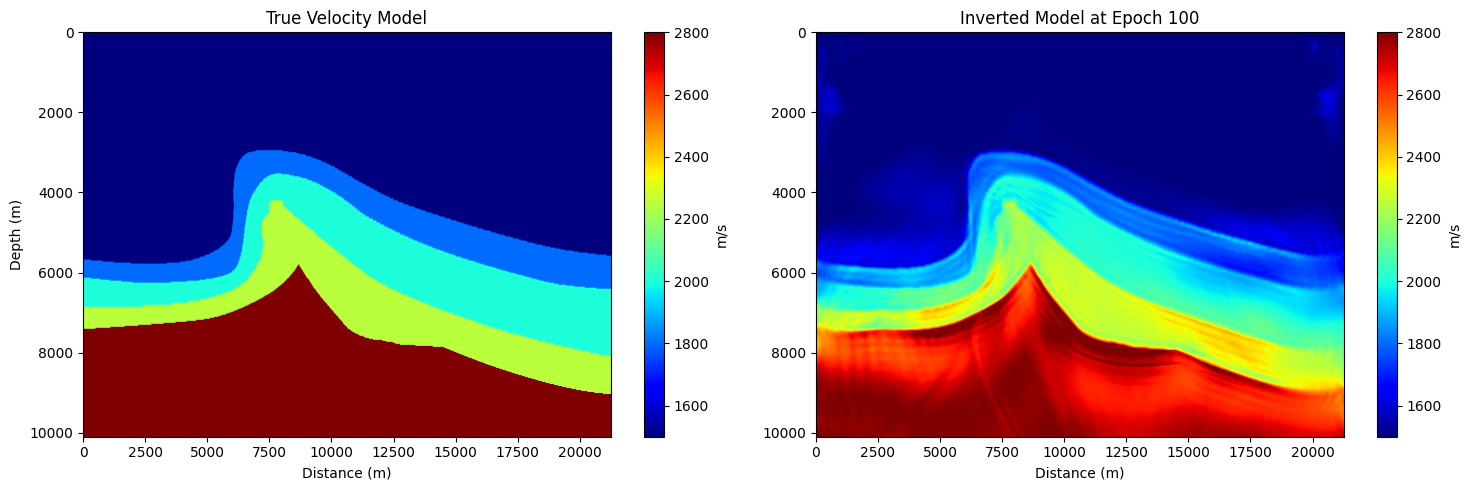

Global Epoch 110 | Local Epoch 110 | Loss: 0.001943
Global Epoch 120 | Local Epoch 120 | Loss: 0.001699
Global Epoch 130 | Local Epoch 130 | Loss: 0.001512
Global Epoch 140 | Local Epoch 140 | Loss: 0.001365
Global Epoch 150 | Local Epoch 150 | Loss: 0.001248


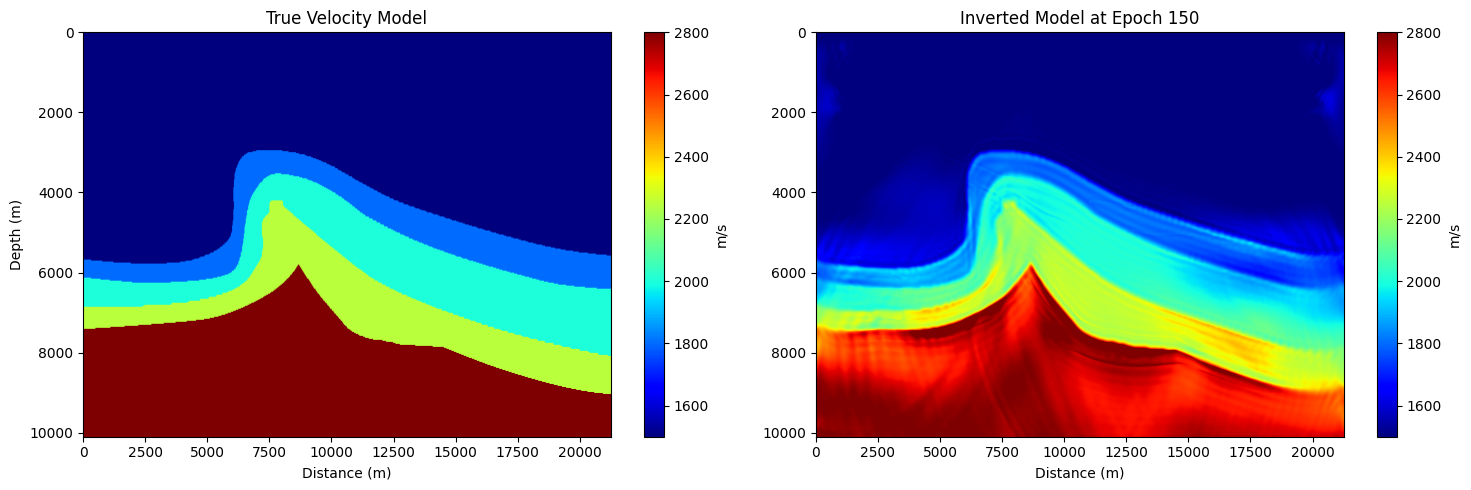


--- STAGE 2: Frequency 7.0 Hz ---
Global Epoch 160 | Local Epoch 010 | Loss: 0.002147
Global Epoch 170 | Local Epoch 020 | Loss: 0.001229
Global Epoch 180 | Local Epoch 030 | Loss: 0.000832
Global Epoch 190 | Local Epoch 040 | Loss: 0.000638
Global Epoch 200 | Local Epoch 050 | Loss: 0.000534


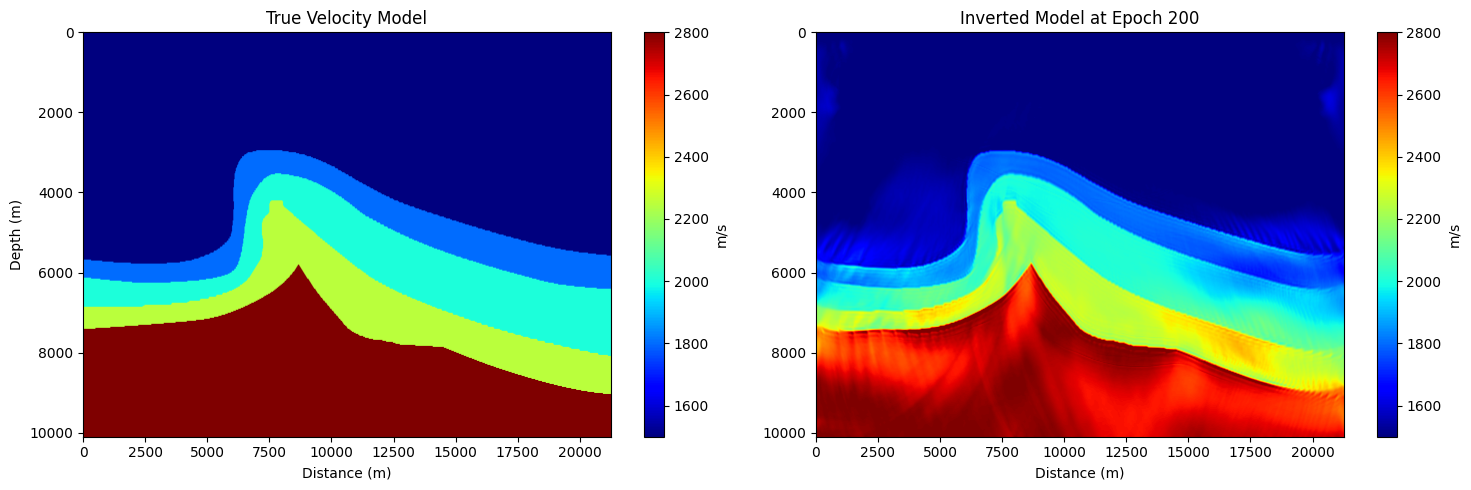

Global Epoch 210 | Local Epoch 060 | Loss: 0.000467
Global Epoch 220 | Local Epoch 070 | Loss: 0.000422
Global Epoch 230 | Local Epoch 080 | Loss: 0.000389
Global Epoch 240 | Local Epoch 090 | Loss: 0.000364
Global Epoch 250 | Local Epoch 100 | Loss: 0.000344


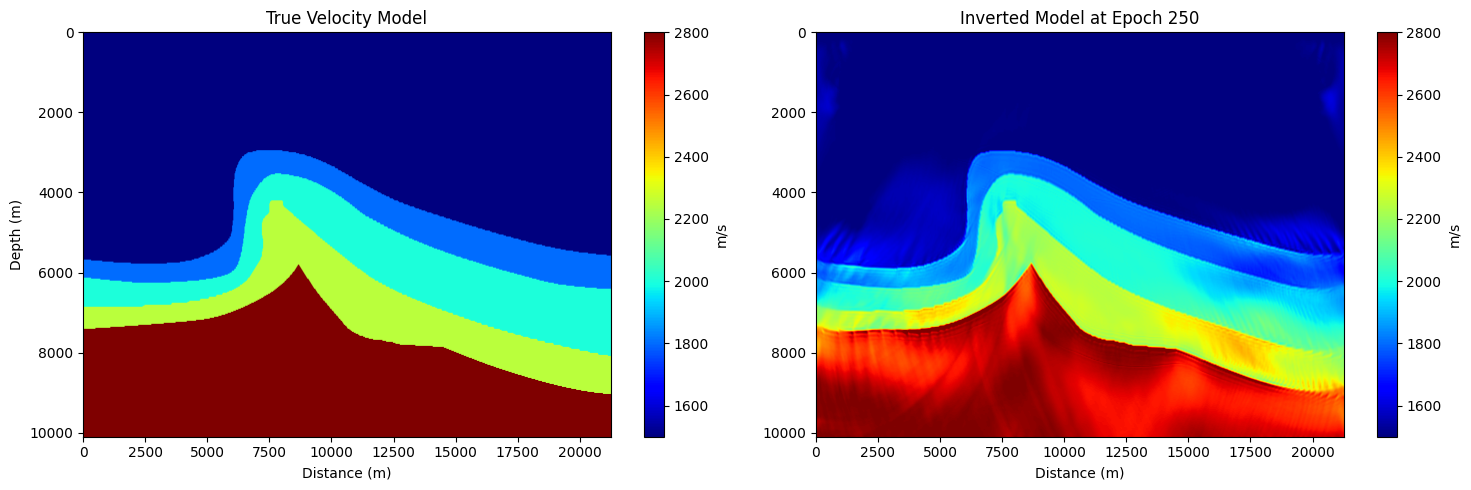

Global Epoch 260 | Local Epoch 110 | Loss: 0.000327
Global Epoch 270 | Local Epoch 120 | Loss: 0.000312
Global Epoch 280 | Local Epoch 130 | Loss: 0.000299
Global Epoch 290 | Local Epoch 140 | Loss: 0.000288
Global Epoch 300 | Local Epoch 150 | Loss: 0.000278


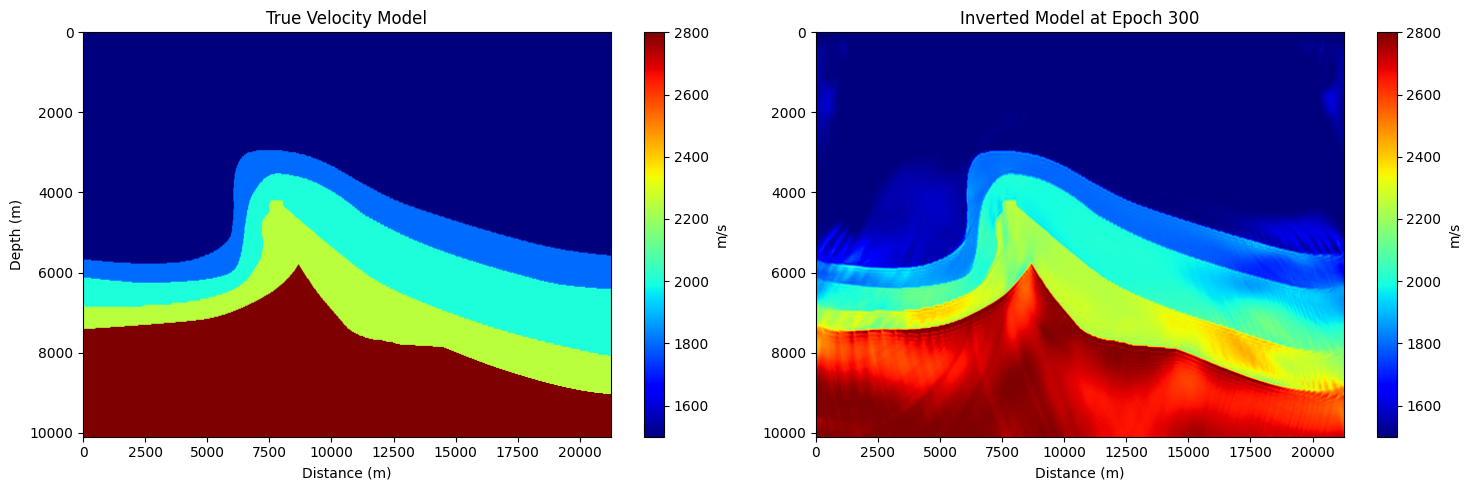

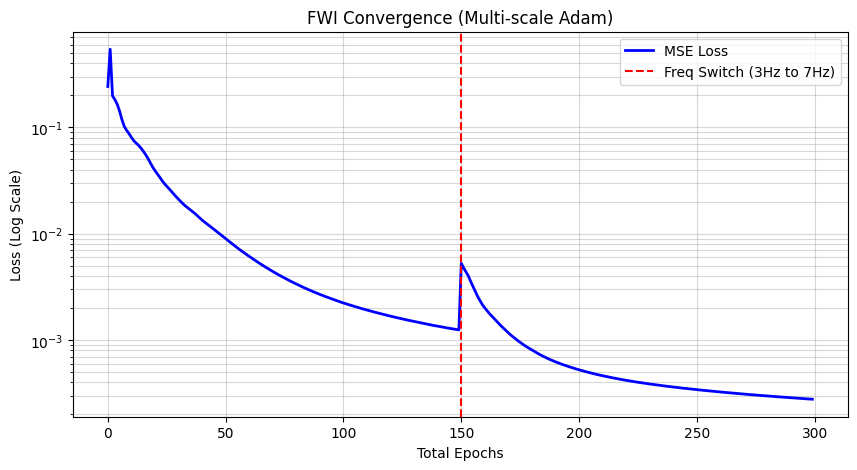

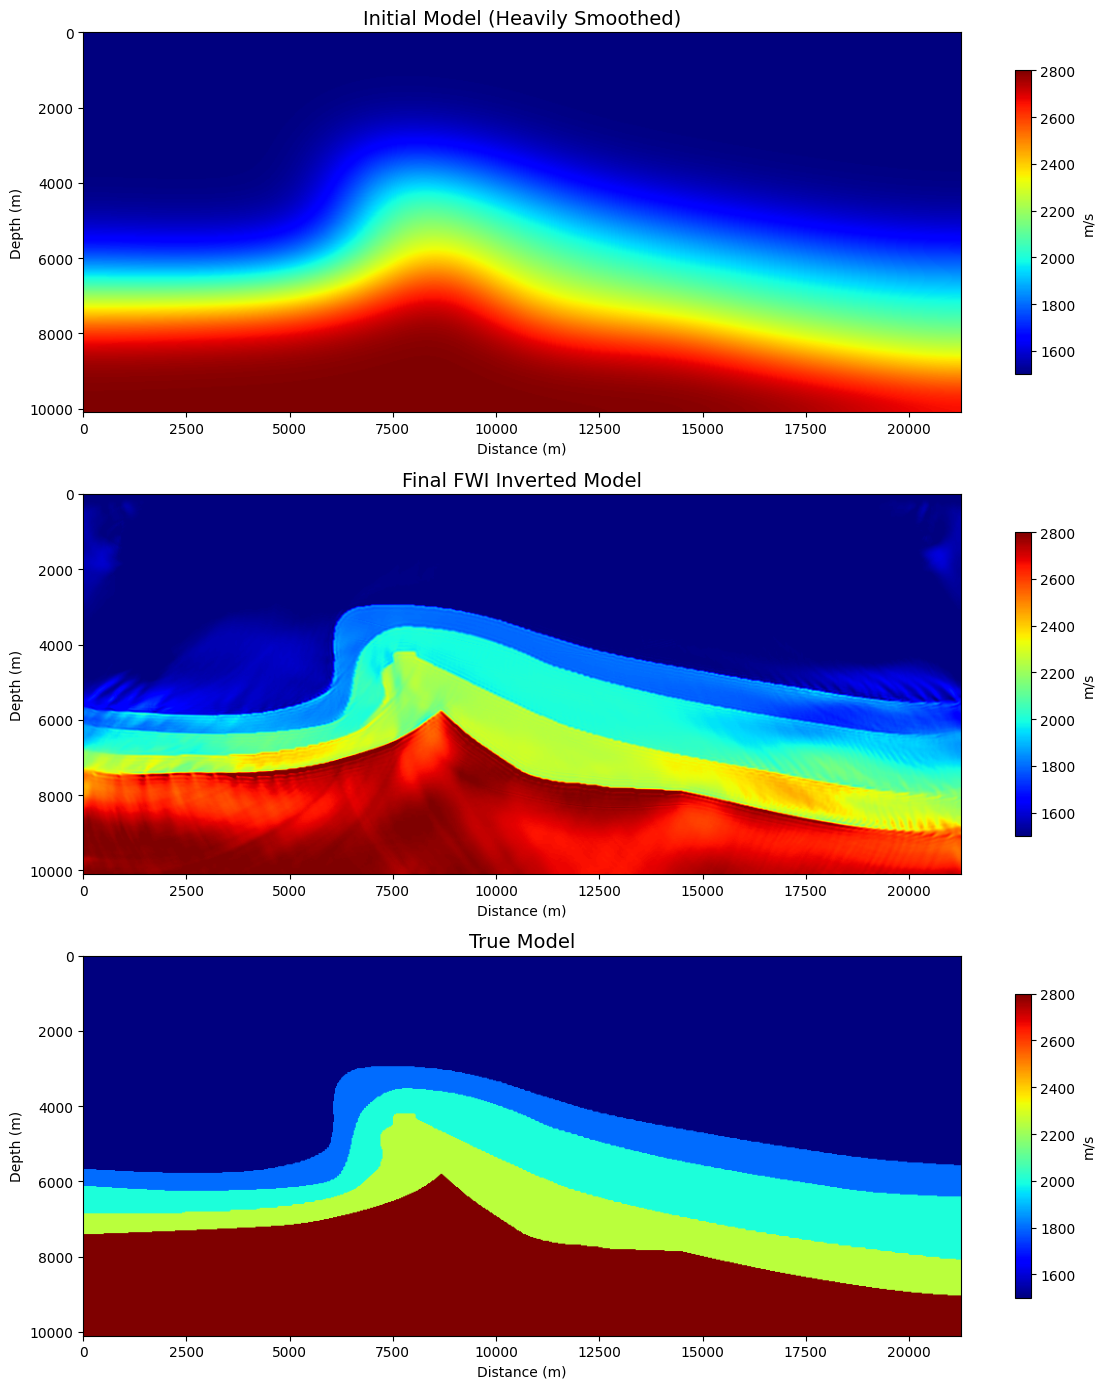

In [2]:
import numpy as np
import torch
import scipy.io
import gc
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import deepwave
from deepwave import scalar

# 0. INITIAL MEMORY CLEAN
gc.collect()
torch.cuda.empty_cache()

# 1. SETTINGS
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# 2. INPUT: ANTICLINE MODEL
mat_path = 'anticline_model.mat'
try:
    mat = scipy.io.loadmat(mat_path)
    v_true_np = None
    for key in mat:
        if isinstance(mat[key], np.ndarray):
            arr = np.squeeze(mat[key])
            if arr.ndim == 2:
                v_true_np = arr.astype(np.float32)
                break
    if v_true_np is None: raise ValueError("Invalid 2D array.")
    if np.max(v_true_np) < 10: v_true_np *= 1000.0
except:
    # Fallback synthetic for demonstration if file not found
    print("Warning: .mat file not found. Using fallback synthetic model.")
    v_true_np = 2000 * np.ones((850, 404), dtype=np.float32)
    v_true_np[:, 250:] = 2800

v_true = torch.from_numpy(v_true_np).to(device)
if v_true.shape[0] < v_true.shape[1]: v_true = v_true.T
nx, nz = v_true.shape

# 3. INITIAL MODEL (Strongly Smoothed)
v_init_np = 1/gaussian_filter(1/v_true.cpu().numpy(), sigma=35) # <------------more smoothening change this line (sigma= __)
v_init = torch.from_numpy(v_init_np).to(device)
v1 = v_init.clone().requires_grad_(True)
vmin, vmax = v_true.min().item(), v_true.max().item()

# 4. GEOMETRY
pml_v = 40
dx, dz = 25.0, 25.0
spacing = (dx, dz)
dt = 0.004
nt = 3000
n_shots = 32 # Balanced for illumination and speed on T4

rx = torch.arange(pml_v, nx - pml_v, device=device)
n_receivers_per_shot = len(rx)

source_loc = torch.zeros(n_shots, 1, 2, dtype=torch.long, device=device)
source_loc[..., 1] = pml_v + 3
source_loc[:, 0, 0] = torch.linspace(pml_v, nx - pml_v, n_shots).to(torch.long)

receiver_loc = torch.zeros(n_shots, n_receivers_per_shot, 2, dtype=torch.long, device=device)
receiver_loc[..., 1] = pml_v + 3
for i in range(n_shots): receiver_loc[i, :, 0] = rx

# 5. MULTI-SCALE STRATEGY & TRACKING
freqs = [3.0, 7.0]
epochs_per_stage = [150, 150]
loss_history = []
global_epoch = 0

# 6. GRADIENT PRECONDITIONER
z_coords = torch.linspace(0, 1, nz, device=device)
z_gain = (z_coords**2 * 40.0 + 1.0).view(1, nz) # Quadratic gain for deep layers
z_gain[:, :15] = 0.0 # Mute the top 15 grid points (shot footprint)

x_gain = torch.ones(nx, device=device)
flank_w = 150
x_gain[:flank_w] = torch.linspace(2.0, 1.0, flank_w, device=device)
x_gain[-flank_w:] = torch.linspace(1.0, 2.0, flank_w, device=device)
full_gain = z_gain * x_gain.view(nx, 1)

# 7. INVERSION
optimizer = torch.optim.Adam([v1], lr=20.0)

print(f"Starting Multi-scale Inversion...")

for stage, (freq, num_epochs) in enumerate(zip(freqs, epochs_per_stage)):
    print(f"\n--- STAGE {stage+1}: Frequency {freq} Hz ---")

    # Generate Ricker for this frequency stage
    source_amp_cpu = deepwave.wavelets.ricker(freq, nt, dt, 1.5/freq).repeat(n_shots, 1, 1)

    # Generate "Observed Data" for this frequency to prevent high-freq noise in early stage
    observed_data_cpu = torch.zeros(n_shots, n_receivers_per_shot, nt)
    with torch.no_grad():
        for i in range(n_shots):
            out = scalar(v_true, spacing, dt, source_amplitudes=source_amp_cpu[i:i+1].to(device),
                         source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                         pml_width=[pml_v]*4, pml_freq=freq)
            observed_data_cpu[i] = out[-1].cpu()
            del out; torch.cuda.empty_cache()

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        epoch_loss = 0
        global_epoch += 1

        # Sequential Shot Loop (T4 VRAM optimization)
        for i in range(n_shots):
            curr_source = source_amp_cpu[i:i+1].to(device)
            curr_obs = observed_data_cpu[i:i+1].to(device)

            out_pred = scalar(v1, spacing, dt, source_amplitudes=curr_source,
                              source_locations=source_loc[i:i+1], receiver_locations=receiver_loc[i:i+1],
                              pml_width=[pml_v]*4, pml_freq=freq)

            loss = torch.nn.MSELoss()(out_pred[-1], curr_obs)
            (loss / n_shots).backward()
            epoch_loss += loss.item()

            del out_pred, curr_source, curr_obs
            torch.cuda.empty_cache()

        # Gradient Processing
        with torch.no_grad():
            if v1.grad is not None:
                v1.grad *= full_gain # Apply depth gain and surface mute

                # Smooth gradient (wider smoothing for low freq stage)
                current_sigma = 4.0 if stage == 0 else 1.5 # <-------------------------more smoothening change this line
                grad_np = gaussian_filter(v1.grad.cpu().numpy(), sigma=current_sigma)
                v1.grad.copy_(torch.from_numpy(grad_np).to(device))

                optimizer.step()
                v1.clamp_(min=vmin, max=vmax)

        loss_history.append(epoch_loss / n_shots)

        # LOGGING
        if (epoch + 1) % 10 == 0:
            print(f"Global Epoch {global_epoch:03d} | Local Epoch {epoch+1:03d} | Loss: {loss_history[-1]:.6f}")

        # VISUALIZATION EVERY 50 EPOCHS
        if global_epoch % 50 == 0:
            fig, ax = plt.subplots(1, 2, figsize=(15, 5))

            im0 = ax[0].imshow(v_true.cpu().numpy().T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax,
                               extent=[0, nx*dx, nz*dz, 0])
            ax[0].set_title("True Velocity Model")
            ax[0].set_ylabel("Depth (m)"); ax[0].set_xlabel("Distance (m)")
            plt.colorbar(im0, ax=ax[0], label='m/s')

            im1 = ax[1].imshow(v1.detach().cpu().numpy().T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax,
                               extent=[0, nx*dx, nz*dz, 0])
            ax[1].set_title(f"Inverted Model at Epoch {global_epoch}")
            ax[1].set_xlabel("Distance (m)")
            plt.colorbar(im1, ax=ax[1], label='m/s')

            plt.tight_layout()
            plt.show()

# 8. FINAL CONVERGENCE PLOT
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='MSE Loss', color='blue', linewidth=2)
plt.yscale('log')
plt.title("FWI Convergence (Multi-scale Adam)")
plt.xlabel("Total Epochs")
plt.ylabel("Loss (Log Scale)")
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.axvline(x=epochs_per_stage[0], color='red', linestyle='--', label='Freq Switch (3Hz to 7Hz)')
plt.legend()
plt.show()

# 9. FINAL COMPARISON PLOTS
fig, ax = plt.subplots(3, 1, figsize=(12, 14))
imgs = [v_init.cpu().numpy(), v1.detach().cpu().numpy(), v_true.cpu().numpy()]
titles = ["Initial Model (Heavily Smoothed)", "Final FWI Inverted Model", "True Model"]

for i in range(3):
    im = ax[i].imshow(imgs[i].T, aspect='auto', cmap='jet', vmin=vmin, vmax=vmax,
                   extent=[0, nx*dx, nz*dz, 0])
    ax[i].set_title(titles[i], fontsize=14)
    ax[i].set_xlabel("Distance (m)")
    ax[i].set_ylabel("Depth (m)")
    fig.colorbar(im, ax=ax[i], label='m/s', shrink=0.8)

plt.tight_layout()
plt.show()